In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import numpy as jnp, random as jr
from jax import tree_util as jtu
from jax import nn, lax

import matplotlib.pyplot as plt

from pymdp.agent import Agent
from pymdp.envs import TMaze

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood
from numpyro.infer import Predictive


/Users/conorheins/Documents/Verses/pymdp/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fitting the parameters of active inference agents performing in the `T-Maze` environment

#### We set up a TMaze instance with 100% reliable cue-->rewarded arm mapping, i.e., the cue unambiguously reveals the location of the rewarding arm. We also fix the rewarded arm --> reward outcome mapping to be highly relaible (98%). THis means if you're in the rewarded arm, you receive a reward 98% of the time, and a punishment 2% of the time. The probabilities are inverted in the punished arm (this is controlled by the `dependent_outcomes=True` flag). 

### We also parameterize 10 different agent/environment pairs (`batch-size=10`), 50 experimental block or episodes per agent, and 5 timesteps per block.



### **Explanatory note on `batch_size`, `subject`, `block`, `timestep`, and `trial` terminology**

#### Experimental data collected from individual participants or subjects in psychological/psychiatric studies often follows a stereotypical, multi-level temporal structure. Typically, each subject participates in a task or study independently from other participants. Each participant performs multiple episodes or blocks of the experiment sequentially (e.g., 20 blocks of 100 trials per block).

#### Depending on the experimental design, these blocks may be independent or have some more sophisticated between-block correlation structure (e.g., the initial task state changes regularly from one block to the next). Within each block, individual "trials" or "timesteps" occur sequentially. There can also be within-block, between-trial correlation structure, and this is an assumption we make in `pymdp`. Namely, we assume that a single active inference process unfolds *across* "trials" or timesteps. The word "trial" itself often refers to independent events that themselves have within-trial temporal structure, so to avoid ambiguity in this notebook we will refer to these as `timesteps`. This is also motivated from the perspective of reinforcement learning / active inference workflows, where these are better understood as timesteps, and "blocks" are better analogized cast as "episodes". 

In [3]:
seed_key = jr.PRNGKey(101)

# setting the parameters for the environment
batch_size = 10 # batch_size, which in this case corresponds to the number of agents to fit in parallel
num_blocks = 50  # number of blocks (number of multi-timestep episodes that are run sequentially, per agent)
num_timesteps = 5 # number of timesteps (or "trials") per block

reward_condition = None # 0 is reward in left arm, 1 is reward in right arm, None is random allocation
reward_probability = 0.98 # 98% chance of reward in the correct arm
punishment_probability = 0.0 # 80% chance of punishment in the other arm
cue_validity = 1.0 # 100% valid cues
dependent_outcomes = True # if True, punishment occurs as a function of reward probability (i.e., if reward probability is 0.8, then 20% punishment). If False, punishment occurs with set probability (i.e., 20% no outcome and punishment will only occur in the other (non-rewarding) arm)

# initialising the environment. see tmaze.py in pymdp/envs for the implementation details.
task = TMaze( 
    batch_size=batch_size, 
    reward_probability=reward_probability,     
    punishment_probability=punishment_probability, 
    cue_validity=cue_validity,          
    reward_condition=reward_condition,
    dependent_outcomes=dependent_outcomes
)

key, _key = jr.split(seed_key)
_, task = task.reset(jr.split(_key, batch_size))

In [4]:
# num_params = 4 # two likelihood contingency params (reward prob, punishment prob), outcome preference param, prior state prob param
num_params = 3 # one likelihood contingency param (reward prob, which also sets punishment prob), outcome preference param, prior state prob param
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")

def transform(z):
    na, np = z.shape

    reward_prob = nn.sigmoid(z[..., 0])
    # punish_prob = nn.sigmoid(z[..., 1])
    lam = nn.softplus(z[..., 1])
    d = nn.sigmoid(z[..., 2])

    A = lax.stop_gradient(task.params["A"])
    B = lax.stop_gradient(task.params["B"])

    one_minus = 1.0 - reward_prob

    reward_left = jnp.stack([reward_prob, one_minus], -1)
    punish_left = jnp.stack([one_minus, reward_prob], -1)
    reward_right = jnp.stack([one_minus, reward_prob], -1)
    punish_right = jnp.stack([reward_prob, one_minus], -1)
    zeros = jnp.zeros_like(reward_left)

    side = jnp.broadcast_to(jnp.array([[1., 1.], [0., 0.], [0., 0.]]), (na, 3, 2))
    left_col = jnp.stack([zeros, reward_left, punish_left], axis=-2)
    right_col = jnp.stack([zeros, reward_right, punish_right], axis=-2)
    A[1] = jnp.stack([side, left_col, right_col, side, side], axis=-2)

    # dependent_cue = False version
    # zeros = jnp.zeros_like(reward_prob)

    # side = jnp.broadcast_to(jnp.array([[1., 1.], [0., 0.], [0., 0.]]), (na, 3, 2))
    # left_col = jnp.stack([
    #     jnp.stack([1 - reward_prob, 1 - punish_prob], -1),
    #     jnp.stack([reward_prob, zeros], -1),
    #     jnp.stack([zeros, punish_prob], -1),
    # ], -2)
    # right_col = jnp.stack([
    #     jnp.stack([1 - punish_prob, 1 - reward_prob], -1),
    #     jnp.stack([zeros, reward_prob], -1),
    #     jnp.stack([punish_prob, zeros], -1),
    # ], -2)
    # A[1] = jnp.stack([side, left_col, right_col, side, side], axis=-2)

    C = [
        jnp.zeros((na, A[0].shape[1])),
        jnp.expand_dims(lam, -1) * jnp.array([0., 1., -1.]),
        jnp.zeros((na, A[2].shape[1])),
    ]
    D = [
        jnp.zeros((na, B[0].shape[1])).at[:, 0].set(1.0),
        jnp.stack([d, 1 - d], -1),
    ]

    return Agent(
        A,
        B,
        C=C,
        D=D,
        policy_len=2,
        A_dependencies=task.dependencies["A"],
        B_dependencies=task.dependencies["B"],
        batch_size=na,
    )


key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params)) / 10

agents = transform(z)

### Sample from the TMaze environment and visualize the results from one block, showing the expected behavior (visit the cue, then choose an arm)

In [5]:
opts_task = {
    "task": task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

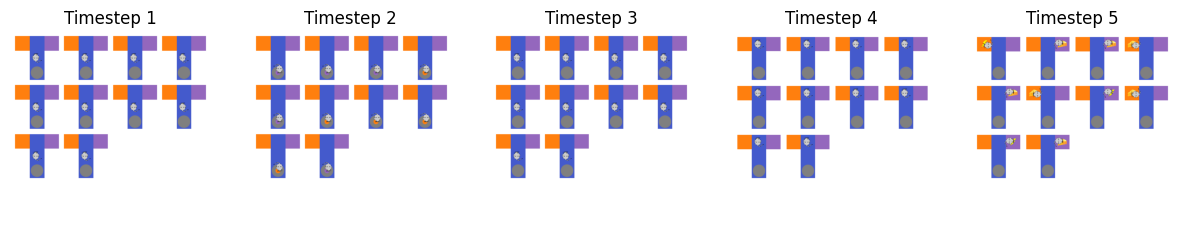

In [6]:
frames = []
for t in range(num_timesteps):  # iterate over timesteps
    # get observations for this timestep
    observations_t = [
        samples["outcomes"][0][0,0,:, t], # subset by predictive sample (first leading dimension) and block (second leading dimension)
        samples["outcomes"][1][0,0,:, t],  
        samples["outcomes"][2][0,0,:, t]   
    ]
    observations_t = jtu.tree_map(lambda x: jnp.expand_dims(x, -1), observations_t) # add lagging dimension as is done before returning in task.step()
       
    frame = task.render(mode="rgb_array", observations=observations_t).astype(jnp.uint8) # render the environment using the observations for this timestep
    plt.close()  # close the figure to prevent memory leak
    frames.append(frame)

frames = jnp.array(frames, dtype=jnp.uint8)

## Make a panel of subplots showing the frames at different timesteps of the video sequence (don't assume mediapy dependency)
fig, axes = plt.subplots(1, num_timesteps, figsize=(15, 5))
for i in range(num_timesteps):
    axes[i].imshow(frames[i])
    axes[i].axis('off')
    axes[i].set_title(f'Timestep {i+1}')
plt.show()

### Inference Method 1: **HMC with NUTS**
#### Use the No U-Turn Sampler (NUTS) for Hamiltonian Monte Carlo sampling-based inference to sample from the parameter posterior. `pybefit` provides useful wrappers for setting up an NUTS-HMC run.

In [7]:
# perform inference on parameters using no-u-turn sampler (NUTS)
# opts_sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
measurements = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

opts_sampling = default_dict_nuts
opts_sampling["num_warmup"] = 400
opts_sampling["num_samples"] = 100
opts_sampling["sampler_kwargs"] = {"kernel": {}, "mcmc": {"progress_bar": True}}
print(opts_sampling)

mcmc_samples, mcmc = run_nuts(model, measurements, opts=opts_sampling)

{'seed': 0, 'num_samples': 100, 'num_warmup': 400, 'sampler_kwargs': {'kernel': {}, 'mcmc': {'progress_bar': True}}}


sample: 100%|██████████| 500/500 [04:25<00:00,  1.88it/s, 7 steps of size 4.92e-01. acc. prob=0.87] 


### Plot each ground truth parameter alongside their posterior means (mean taken over parallel HMC samples/chains)

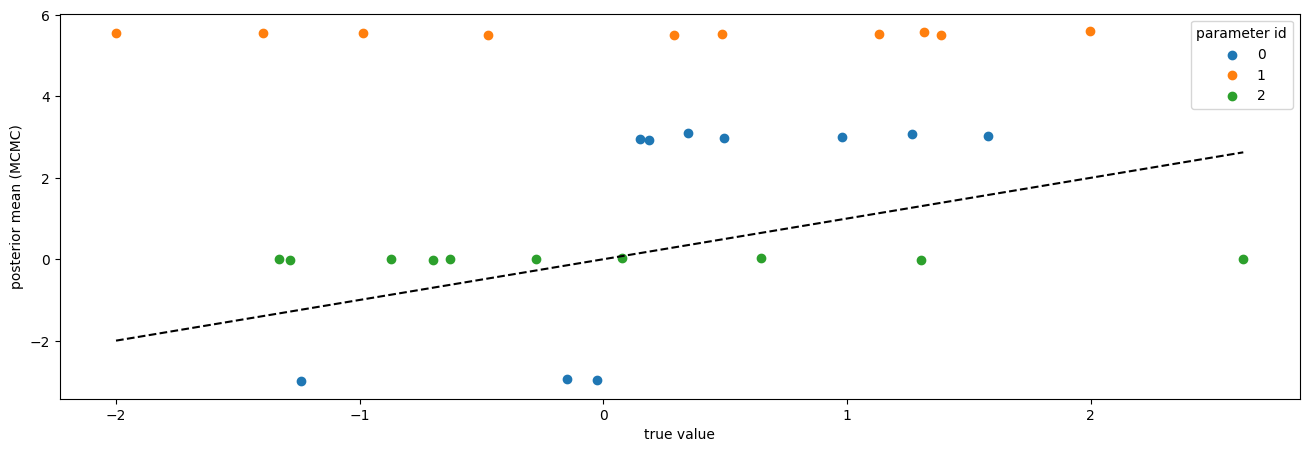

In [12]:
plt.figure(figsize=(16, 5))
ground_truth_z = samples['z'][0]
for i in range(num_params):
    plt.scatter(ground_truth_z[:, i], mcmc_samples["z"].mean(0)[:, i], label=i)

plt.plot((ground_truth_z.min(), ground_truth_z.max()), (ground_truth_z.min(), ground_truth_z.max()), "k--")
plt.ylabel("posterior mean (MCMC)")
plt.xlabel("true value")
plt.legend(title="parameter id")

### Transform the latent parameter corresponding to the reward probability into probability space and investigate overlap between ground-truth and inferred parameter

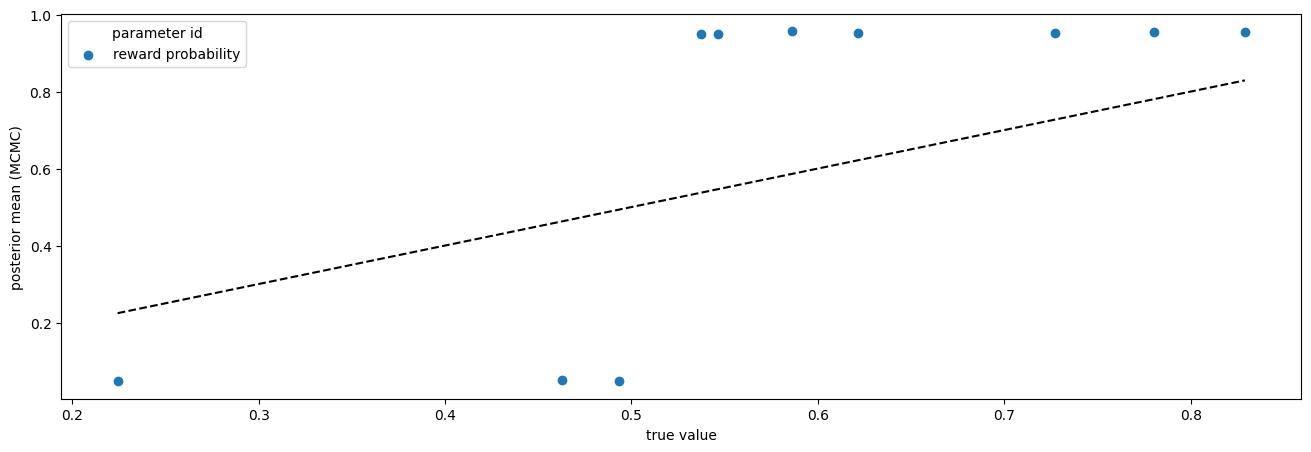

In [ ]:
inferred_reward_probabilities = nn.sigmoid(mcmc_samples["z"].mean(0)[:, 0])
ground_truth_reward_probabilities = nn.sigmoid(ground_truth_z[:, 0])

plt.figure(figsize=(16, 5))
plt.scatter(ground_truth_reward_probabilities, inferred_reward_probabilities, label="reward probability")

plt.plot((ground_truth_reward_probabilities.min(), ground_truth_reward_probabilities.max()), (ground_truth_reward_probabilities.min(), ground_truth_reward_probabilities.max()), "k--")
plt.ylabel("posterior mean (NUTS-HMC)")
plt.xlabel("true value")
plt.legend(title="parameter id")

### Inference Method 2: **Black-Box Stochastic Variational Inference**
#### Use numpyro's `SVI` functionality to run variational inference with a MultivariateNormal variational posterior (i.e., a Normal Guide). SVI runs a form of black box variational inference, where ELBO gradients are estimated using samples from the guide. The allows to use of much less constrained, black-box likelihood functions, removing the restrictions of traditional mean-field variational Bayesian treatments where likelioods are often constrained to be in e.g., the conjugate-exponential family.

In [ ]:
# perform inference on parameters using black-box stochastic variational inference (SVI in numpyro)
# opts_svi dictionary can be used to specify various parameters
# for the SVI optimization algorithm
measurements = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1_000}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurements, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


 47%|████▋     | 470/1000 [02:58<03:18,  2.67it/s, init loss: 3702.4609, avg. loss [401-450]: 2589.8284]

### Plot the variational free energy over time (negative ELBO)

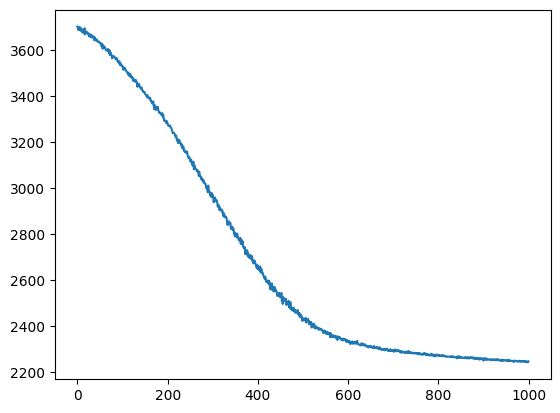

In [15]:
plt.plot(results.losses)

### Plot each ground truth parameter alongside their posterior means (mean taken over posterior samples from the guide)

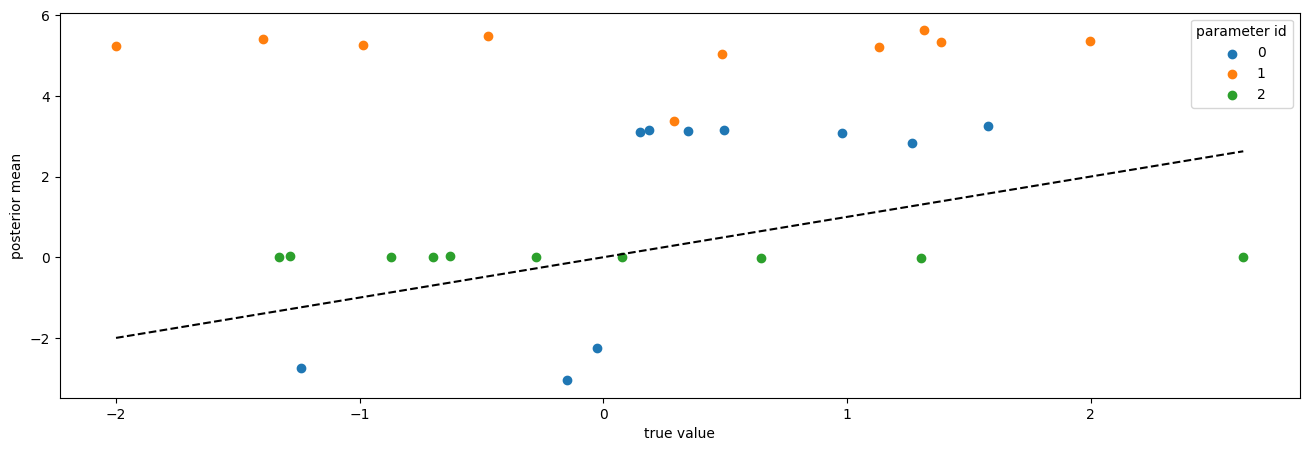

In [ ]:
plt.figure(figsize=(16, 5))
ground_truth_z = samples['z'][0]
for i in range(num_params):
    plt.scatter(ground_truth_z[:, i], svi_samples["z"].mean(0)[:, i], label=i)

plt.plot((ground_truth_z.min(), ground_truth_z.max()), (ground_truth_z.min(), ground_truth_z.max()), "k--")
plt.ylabel("posterior mean (SVI)")
plt.xlabel("true value")
plt.legend(title="parameter id")

### Transform the latent parameter corresponding to the reward probability into probability space and investigate overlap between ground-truth and inferred parameter

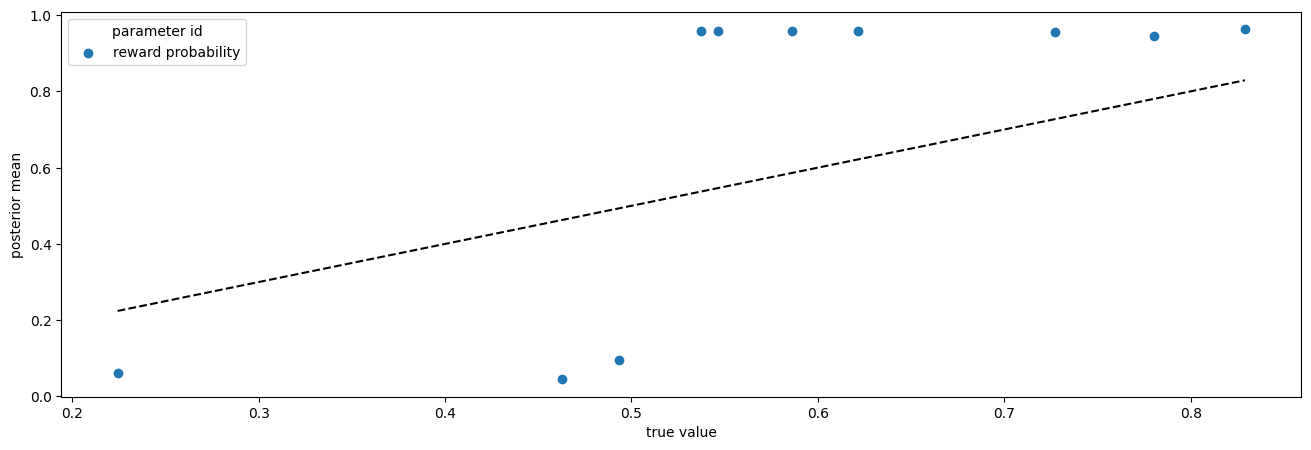

In [ ]:
inferred_reward_probabilities = nn.sigmoid(svi_samples["z"].mean(0)[:, 0])
ground_truth_reward_probabilities = nn.sigmoid(ground_truth_z[:, 0])

plt.figure(figsize=(16, 5))
plt.scatter(ground_truth_reward_probabilities, inferred_reward_probabilities, label="reward probability")

plt.plot((ground_truth_reward_probabilities.min(), ground_truth_reward_probabilities.max()), (ground_truth_reward_probabilities.min(), ground_truth_reward_probabilities.max()), "k--")
plt.ylabel("posterior mean (SVI)")
plt.xlabel("true value")
plt.legend(title="parameter id")